In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler
import torchvision.transforms as transforms
import time
import os

import torchvision
from torchvision import datasets, models
import matplotlib.pyplot as plt

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
import seaborn as sns

In [4]:
sns.set_theme()

# 0. Load Data

In [19]:
path = 'converted-data'

In [20]:
# Resize images to 288 x 288
transform = transforms.Compose([transforms.Resize((288, 288)),
                                transforms.ToTensor()])

# Normalize the data later!!

# TRANSFORMING THE DATA
data = torchvision.datasets.ImageFolder(path, transform=transform)

In [21]:
train_data, valtest_data = random_split(data, (15587, 1948*2))
val_data, test_data = random_split(valtest_data, (1948, 1948))

# 1. Define CNN Models

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.name = "CNN"
        self.conv1 = nn.Conv2d(3, 5, 7) # RGB 3 input channels, 5 output channels, 7 x 7 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv2 = nn.Conv2d(5, 10, 7) # 5 input channels, 10 output channels, 7 x 7 kernel size
        self.pool = nn.MaxPool2d(3, 1) # 3 x 3 kernel size, 1 stride
        self.conv3 = nn.Conv2d(10, 15, 3) # 10 input channels, 15 output channels, 3 x 3 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv4 = nn.Conv2d(15, 20, 3) # 15 input channels, 20 output channels, 3 x 3 kernel size

        # 26 x 26 (20ch) => flat => 26 x 26 x 20
        # self.fc1 = nn.Linear(20 * 26 * 26, 50) # 50 hidden neurons
        self.fc1 = nn.Linear(10 * 29 * 29, 50)
        self.fc2 = nn.Linear(50, 6) # 6 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, 20 * 26 * 26)
        x = x.view(-1, 10 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # flatten to [batch_size]
        return x

In [6]:
'''
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.name = "CNN2"
        self.conv1 = nn.Conv2d(3, 5, 7) # RGB 3 input channels, 5 output channels, 7 x 7 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv2 = nn.Conv2d(5, 10, 7) # 5 input channels, 10 output channels, 5 x 5 kernel size
        self.pool = nn.MaxPool2d(3, 1) # 3 x 3 kernel size, 1 stride
        self.conv3 = nn.Conv2d(10, 15, 3) # 10 input channels, 15 output channels, 3 x 3 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv4 = nn.Conv2d(15, 20, 3) # 15 input channels, 20 output channels, 3 x 3 kernel size

        # 26 x 26 (20ch) => flat => 26 x 26 x 20
        # self.fc1 = nn.Linear(20 * 26 * 26, 50) # 50 hidden neurons
        self.fc1 = nn.Linear(10 * 29 * 29, 50)
        self.fc2 = nn.Linear(50, 6) # 6 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, 20 * 26 * 26)
        x = x.view(-1, 10 * 29 * 29)
        x = F.softmax(self.fc1(x), dim=1)
        x = self.fc2(x)
        x = x.squeeze(1) # flatten to [batch_size]
        return x
'''

In [26]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.name = "CNN2"
        self.conv1 = nn.Conv2d(3, 5, 7) # RGB 3 input channels, 5 output channels, 7 x 7 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv2 = nn.Conv2d(5, 10, 7) # 5 input channels, 10 output channels, 5 x 5 kernel size
        self.pool = nn.MaxPool2d(3, 1) # 3 x 3 kernel size, 1 stride
        self.conv3 = nn.Conv2d(10, 15, 3) # 10 input channels, 15 output channels, 3 x 3 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv4 = nn.Conv2d(15, 20, 3) # 15 input channels, 20 output channels, 3 x 3 kernel size

        # 26 x 26 (20ch) => flat => 26 x 26 x 20
        # self.fc1 = nn.Linear(20 * 26 * 26, 50) # 50 hidden neurons
        self.fc1 = nn.Linear(10 * 29 * 29, 50)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(50, 6) # 6 classes
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, 20 * 26 * 26)
        x = x.view(-1, 10 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = x.squeeze(1) # flatten to [batch_size]
        return x

In [7]:
class CNN3(nn.Module):
    def __init__(self):
        super(CNN3, self).__init__()
        self.name = "CNN3"
        self.conv1 = nn.Conv2d(3, 5, 7) # RGB 3 input channels, 5 output channels, 7 x 7 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv11 = nn.Conv2d(5, 5, 1) # Pointwise convolution
        self.conv2 = nn.Conv2d(5, 10, 7) # 5 input channels, 10 output channels, 7 x 7 kernel size
        self.pool = nn.MaxPool2d(3, 1) # 3 x 3 kernel size, 1 stride
        self.conv22 = nn.Conv2d(10, 10, 1) # Pointwise convolution
        self.conv3 = nn.Conv2d(10, 15, 3) # 10 input channels, 15 output channels, 3 x 3 kernel size
        self.pool = nn.MaxPool2d(3, 3) # 3 x 3 kernel size, 3 stride
        self.conv33 = nn.Conv2d(15, 15, 1) # Pointwise convolution
        self.conv4 = nn.Conv2d(15, 20, 3) # 15 input channels, 20 output channels, 3 x 3 kernel size

        # 26 x 26 (20ch) => flat => 26 x 26 x 20
        # self.fc1 = nn.Linear(20 * 26 * 26, 50) # 50 hidden neurons
        self.fc1 = nn.Linear(10 * 29 * 29, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # x = x.view(-1, 20 * 26 * 26)
        x = x.view(-1, 10 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = x.squeeze(1) # flatten to [batch_size]
        return x

## 1.1. Define Best Model

In [12]:
use_cuda = True
best_model = CNN() # Change this line
best_model_path = "saved-models/model_{0}_bs{1}_lr{2}_epoch{3}".format("CNN", 128, 0.01, 9) # Change this line
state = torch.load(best_model_path)
best_model.load_state_dict(state)
if use_cuda and torch.cuda.is_available():
    best_model.cuda()

# 2. True Positive and False Positive Rates (Not Good Metric?)

In [7]:
def accuracy_per_class(model, data):
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
        device = torch.device("cuda:0" is torch.cuda.is_available())
    else:
        device = torch.device("cpu")    
    #######################################

    model = model.to(device)
    model.eval()
    loader = torch.utils.data.DataLoader(data, batch_size=1, num_workers=1, shuffle=True)

    errors = { 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0 } # for a given true class, how many times did we guess wrong?
    total = { 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0 } # total number of samples for each true class
    wrong_guesses = { 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0 } # for each predicted class, how many were incorrect?
    guesses = { 0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0 } # total number of samples for each predicted class

    softmax = nn.Softmax(dim=1)
    for img, label in iter(loader):
        if torch.cuda.is_available():
            img = img.to('cuda')
            label = label.to('cuda')
        output = softmax(model(img))
        pred = np.argmax(output.detach().cpu()).item()
        truth = label.cpu().item()
        if pred != truth:
            errors[truth] += 1
            wrong_guesses[pred] += 1
        total[truth] += 1
        guesses[pred] += 1

    for i in range(6):
        if guesses[i] == 0:
            wrong_guesses[i] = guesses[i]
        else: 
            wrong_guesses[i] /= guesses[i]
        if total[i] == 0:
            errors[i] = 0
        else:
            errors[i] /= total[i]
    
    return errors, wrong_guesses, guesses, total

<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\steph\AppData\Local\Temp\ipykernel_45824\3471556104.py:5: SyntaxWarning: "is" with a literal. Did you mean "=="?
  device = torch.device("cuda:0" is torch.cuda.is_available())


In [12]:
def plot_accuracy_per_class(model, data):
    error_rate, wrong_guess_rate, guesses, total = accuracy_per_class(model, data)

    print("Error rate")
    print(error_rate)
    print("Wrong guess rate")
    print(wrong_guess_rate)
    print("Guesses")
    print(guesses)
    print("Total")
    print(total)

    x = np.array([0, 1, 2, 3, 4, 5])
    xtick = ["angry", "disgust", "fear", "happy", "neutral", "sad"]

    plt.xticks(x, xtick, rotation=45)
    plt.plot(x, error_rate.values())
    plt.title("Error rate per class")
    plt.xlabel("Class")
    plt.ylabel("Error rate")
    plt.show()

    plt.xticks(x, xtick, rotation=45)
    plt.plot(x, total.values())
    plt.title("Total samples per class")
    plt.xlabel("Class")
    plt.ylabel("Number of samples")
    plt.show()

    plt.xticks(x, xtick, rotation=45)
    plt.plot(x, wrong_guess_rate.values())
    plt.title("Wrong guess rate per class")
    plt.xlabel("Class")
    plt.ylabel("Wrong guess rate")
    plt.show()

    plt.xticks(x, xtick, rotation=45)
    plt.plot(x, guesses.values())
    plt.title("Guesses per class")
    plt.xlabel("Class")
    plt.ylabel("Number of guesses")
    plt.show()

In [ ]:
plot_accuracy_per_class(best_model, test_data)

# 3. AUC Curve and Plot Predictions

In [8]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [11]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

In [12]:
def get_auc_vars(model, data):
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
        device = torch.device("cuda:0" is torch.cuda.is_available())
    else:
        device = torch.device("cpu")    
    #######################################

    model = model.to(device)
    model.eval()
    loader = torch.utils.data.DataLoader(data, batch_size=1, num_workers=1, shuffle=True)

    actuals, predictions, data_images = [], [], []

    # To disable gradients
    with torch.no_grad():
        k = 0
        for images, labels in loader:
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.long)

            # Prediction
            out = model(images)
            actuals.extend(labels.cpu().numpy().astype(int))
            predictions.extend(F.softmax(out, 1).cpu().numpy())
            data_images.extend(images)

    # Prepare predictions and actuals
    actuals = np.array(actuals)
    predictions = np.array(predictions)

    # Choose label (array)
    predicted_labels = predictions.argmax(1)

    return actuals, predictions, predicted_labels, data_images

<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\steph\AppData\Local\Temp\ipykernel_32224\655032251.py:4: SyntaxWarning: "is" with a literal. Did you mean "=="?
  device = torch.device("cuda:0" is torch.cuda.is_available())


In [13]:
def plot_roc_curve(y_test, y_pred):
  n_classes = len(np.unique(y_test))
  y_test = label_binarize(y_test, classes=np.arange(n_classes))

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  thresholds = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_pred[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  # Plot all ROC curves
  lw = 1
  plt.plot(fpr["micro"], tpr["micro"],
  label="Micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
  linestyle=":", linewidth=4,)

  plt.plot(fpr["macro"], tpr["macro"],
  label="Macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
  linestyle=":", linewidth=4,)

  for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=lw, label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], "k--", lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver Operating Characteristic (ROC) curve")
  plt.legend(fontsize='x-small')

In [14]:
def get_roc_auc_full(model, data):
    actuals, predictions, _, _ = get_auc_vars(model, data)
    plot_roc_curve(actuals, predictions)

In [15]:
def get_visual_pred(model, data):
    actuals, _, predicted_labels, data_images = get_auc_vars(model, data)

    classes = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad"}

    for k in range(24):
        title = str(classes[actuals[k]]) + " | " + str(classes[predicted_labels[k]])

        # since batch_size = 1, there is only 1 image in `images`
        image = data_images[k]
        # place the colour channel at the end, instead of at the beginning
        img = np.transpose(image, [1, 2, 0])
        # normalize pixel intensity values to [0, 1]
        plt.subplot(4, 6, k+1)
        plt.title(title, fontsize=7)
        plt.axis('off')
        plt.imshow(img)

    accuracy = (predicted_labels == actuals).mean()

    print("Accuracy: ", accuracy)

In [16]:
from itertools import cycle

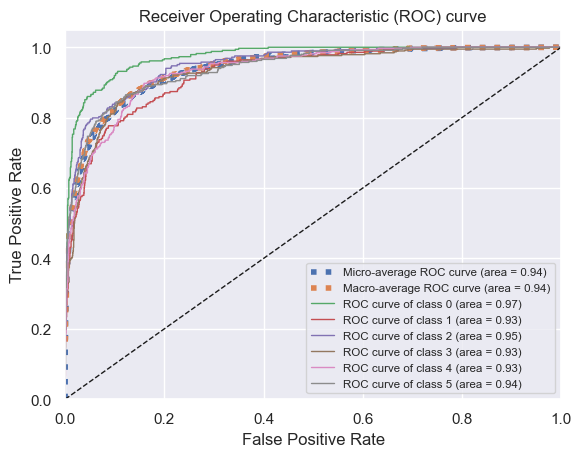

In [116]:
get_roc_auc_full(best_model, test_data)

Accuracy:  0.731006160164271


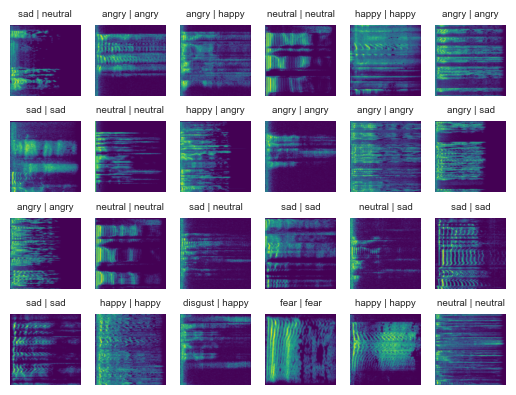

In [117]:
get_visual_pred(best_model, test_data)

# 4. Confusion Matrix

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

In [18]:
def get_confusion_matrix(model, data):
    y_true, _, y_pred, _ = get_auc_vars(model, data)

    fig, ax = plt.subplots()

    sns.heatmap(metrics.confusion_matrix(y_true, y_pred), annot=True, cbar=False, fmt='d', cmap='Reds')
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title('Confusion matrix')

    target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
    print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       angry       0.78      0.85      0.82       336
     disgust       0.81      0.51      0.62       278
        fear       0.81      0.67      0.73       284
       happy       0.67      0.81      0.73       380
     neutral       0.72      0.68      0.70       322
         sad       0.69      0.80      0.74       348

    accuracy                           0.73      1948
   macro avg       0.75      0.72      0.72      1948
weighted avg       0.74      0.73      0.73      1948



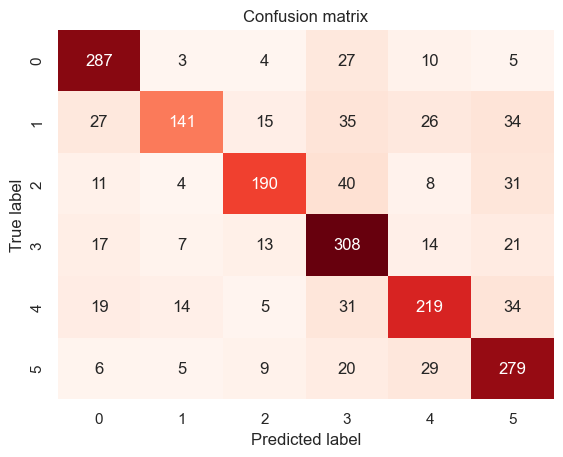

In [18]:
get_confusion_matrix(best_model, test_data)

# 5. Test with Our Data

## 5.0.1. Jennifer's Model

In [22]:
use_cuda = True
best_model = CNN3() # Change this line
best_model_path = "extra-team-models/model_{0}_bs{1}_lr{2}_epoch{3}".format("CNN3", 64, 0.005, 19) # Change this line
state = torch.load(best_model_path)
best_model.load_state_dict(state)
if use_cuda and torch.cuda.is_available():
    best_model.cuda()

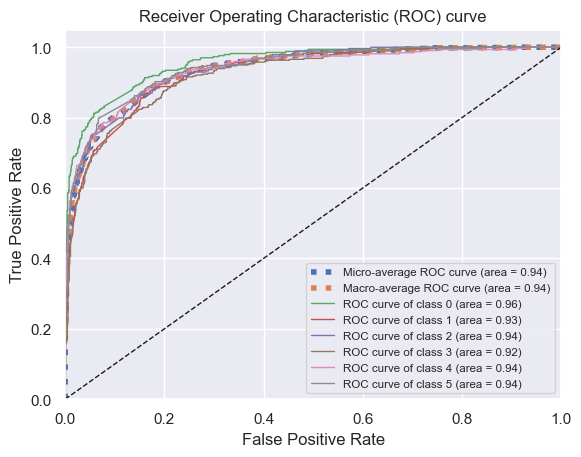

In [23]:
get_roc_auc_full(best_model, test_data)

Accuracy:  0.7094455852156057


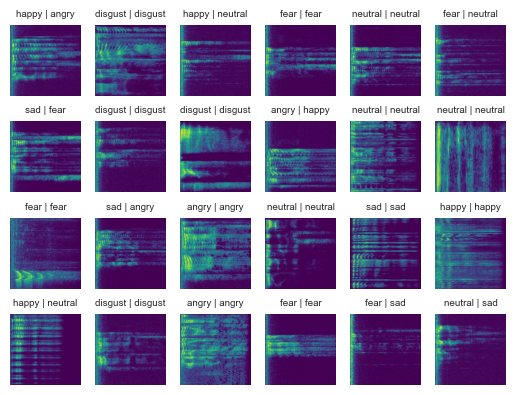

In [24]:
get_visual_pred(best_model, test_data)

              precision    recall  f1-score   support

       angry       0.62      0.83      0.71       336
     disgust       0.73      0.62      0.67       278
        fear       0.80      0.63      0.71       284
       happy       0.73      0.67      0.70       380
     neutral       0.67      0.77      0.72       322
         sad       0.78      0.72      0.75       348

    accuracy                           0.71      1948
   macro avg       0.72      0.71      0.71      1948
weighted avg       0.72      0.71      0.71      1948



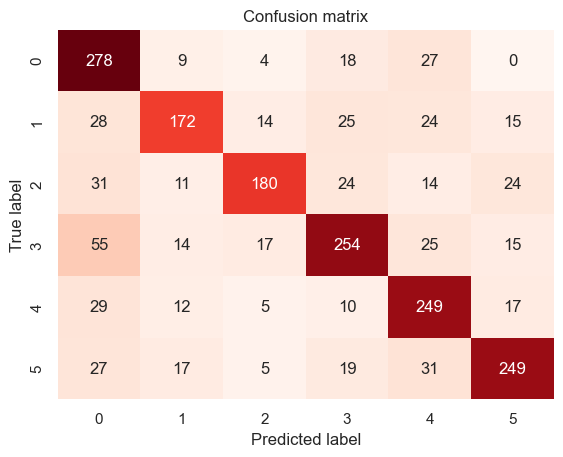

In [25]:
get_confusion_matrix(best_model, test_data)

## 5.0.2 Esther's Model

In [27]:
use_cuda = True
best_model = CNN2() # Change this line
best_model_path = "extra-team-models/model_{0}_bs{1}_lr{2}_epoch{3}".format("CNN2", 256, 0.005, 9) # Change this line
state = torch.load(best_model_path)
best_model.load_state_dict(state)
if use_cuda and torch.cuda.is_available():
    best_model.cuda()

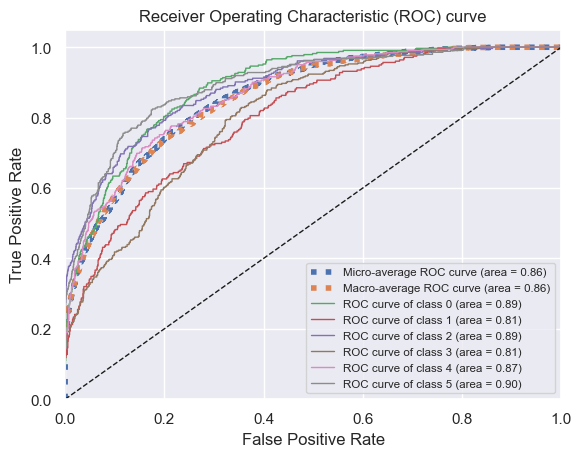

In [28]:
get_roc_auc_full(best_model, test_data)

Accuracy:  0.5462012320328542


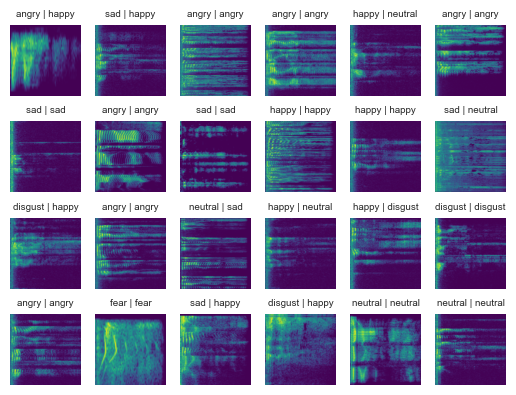

In [29]:
get_visual_pred(best_model, test_data)

              precision    recall  f1-score   support

       angry       0.56      0.60      0.58       336
     disgust       0.48      0.33      0.39       278
        fear       0.72      0.46      0.56       284
       happy       0.49      0.48      0.48       380
     neutral       0.52      0.64      0.58       322
         sad       0.56      0.72      0.63       348

    accuracy                           0.55      1948
   macro avg       0.56      0.54      0.54      1948
weighted avg       0.55      0.55      0.54      1948



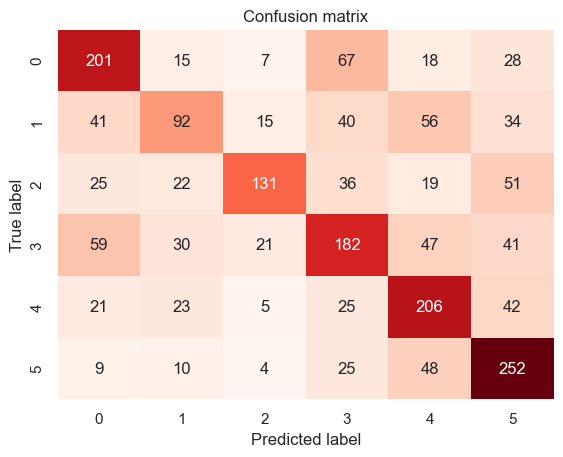

In [30]:
get_confusion_matrix(best_model, test_data)

## 5.1. Kids are talking by the door

In [ ]:
path = None
# Resize images to 288 x 288
transform = transforms.Compose([transforms.Resize((288, 288)),
                                transforms.ToTensor()])

# Normalize the data later!!

# TRANSFORMING THE DATA
our_data1 = torchvision.datasets.ImageFolder(path, transform=transform)

In [ ]:
get_roc_auc_full(best_model, our_data1)

In [ ]:
get_visual_pred(best_model, our_data1)

In [ ]:
get_confusion_matrix(best_model, our_data1)

## 5.2. We love APS360